# Data exploration
Fetch some time series from BRO and DINO via different methods.

In [1]:
import random, pickle, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../../src')
import utils_bro, utils_dino

In [ ]:
GLD_ID_1 = "GLD000000054694" # BRO-ID
GLD_ID_2 = "GLD000000050281" # BRO-ID

In [ ]:
# via Rest-API
bro_1_df = utils_bro.get_bro_data(GLD_ID_1)
bro_2_df = utils_bro.get_bro_data(GLD_ID_2)
# via CSV download
dino_df = pd.read_csv("../../data/B31B0190_001_full.csv", skiprows=14, usecols=['Peildatum', 'Stand (cm t.o.v NAP)'])
bro_0_df = pd.read_csv("../../data/GLD000000057428_full.csv", skiprows=9, usecols=['tijdstip meting', 'waterstand'])

## Plot

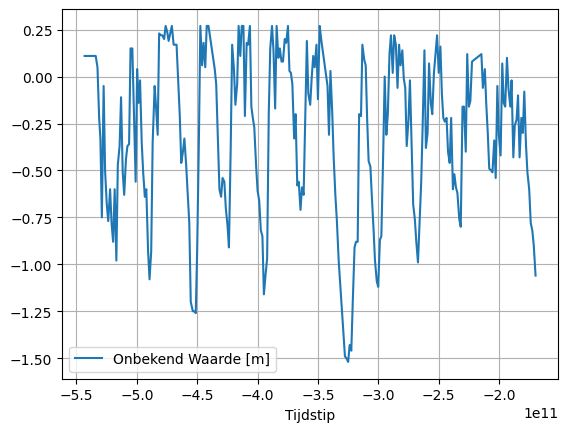

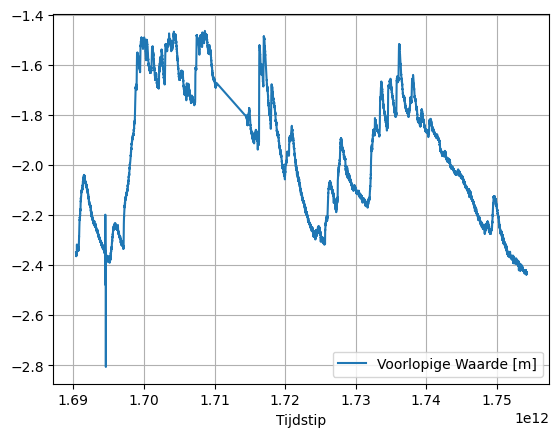

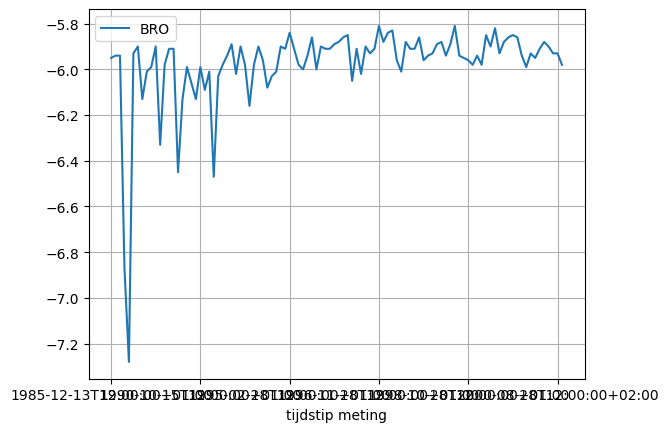

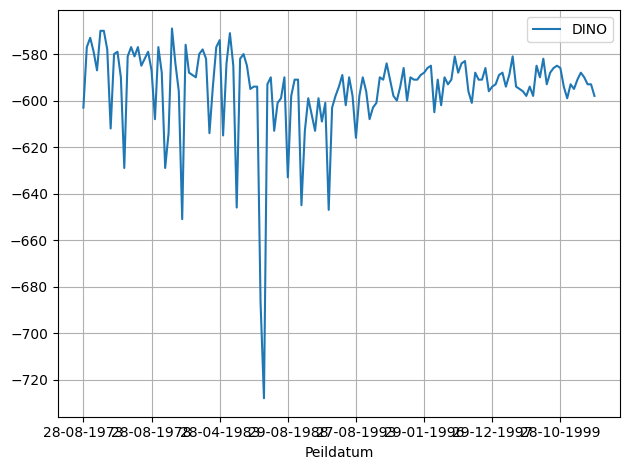

In [ ]:
bro_1_df.plot(x='Tijdstip', y=bro_1_df.columns[1], kind='line', grid=True)
bro_2_df.plot(x='Tijdstip', y=bro_2_df.columns[1], kind='line', grid=True)
bro_0_df.plot(x='tijdstip meting', y='waterstand', kind='line', grid=True, label='BRO')
dino_df.plot(x='Peildatum', y='Stand (cm t.o.v NAP)', kind='line', grid=True, label='DINO')
plt.tight_layout()

## Normalization and standardization
We nomalize the data to make it comparable (in magnitude).
Additionally, the time-series do not have the same lenght nor the same sampling rate, nor the same date format. We convert all times to the same format (Unix) and store it in a separate dictionary times`.

In [ ]:
# Normalization
s1 = bro_1_df[bro_1_df.columns[1]].values
s2 = bro_2_df[bro_2_df.columns[1]].values
s3 = dino_df['Stand (cm t.o.v NAP)'].values
s4 = bro_0_df['waterstand'].dropna().values
s1 = (s1 - np.mean(s1))/np.std(s1)
s2 = (s2 - np.mean(s2))/np.std(s2)
s3 = (s3 - np.mean(s3))/np.std(s3)
s4 = (s4 - np.mean(s4))/np.std(s4)
print(f"Mean bro_1: {np.mean(s1)}, std bro_1: {np.std(s1)}, length bro_1: {len(s1)}")
print(f"Mean bro_2: {np.mean(s2)}, std bro_2: {np.std(s2)}, length bro_2: {len(s2)}")
print(f"Mean dino: {np.mean(s3)}, std dino: {np.std(s3)}, length dino: {len(s3)}")
print(f"Mean bro_0: {np.mean(s4)}, std bro_0: {np.std(s4)}, length bro_0: {len(s4)}")

Mean bro_1: -1.3664283380001927e-17, std bro_1: 1.0, length bro_1: 260
Mean bro_2: 5.313430179366327e-16, std bro_2: 1.0, length bro_2: 16582
Mean dino: 1.5469597641134632e-15, std dino: 1.0, length dino: 151
Mean bro_0: -8.23969841158921e-15, std bro_0: 0.9999999999999998, length bro_0: 102


In [ ]:
t1 = bro_1_df['Tijdstip'].values
t2 = bro_2_df['Tijdstip'].values
t3 = dino_df['Peildatum'].values
t4 = bro_0_df['tijdstip meting'].dropna().values

In [ ]:
import re
def parse_date_to_unix(timestamps, default_tz='UTC'):
    """
    Convert ISO 8601 or date-only strings to Unix time (seconds since epoch).
    For date-only values, set time to midnight.
    
    Args:
        timestamps: list of strings (ISO or date-only)
        default_tz: timezone to assume if none provided, univ time is in UTC format
        dayfirst: interpret day-first for date-only formats like '28-08-1973' as given by BRO because we are in Europe.
    
    Returns:
        list of floats (Unix time in seconds)
    """
    _YFIRST = re.compile(r"^\d{4}[-/]\d{1,2}[-/]\d{1,2}")
    unix_times = []
    for ts in timestamps:
        if not isinstance(ts, str): 
            raise ValueError("Timestamps must be strings")
        ts = ts.strip()
        if not ts:
            unix_times.append(None)
            continue
        try:
            if _YFIRST.match(ts) or "T" in ts: # ISO & Y-first
                dt = pd.to_datetime(ts, utc=True)  
            else:  # Day-first branch
                dt = pd.to_datetime(ts, dayfirst=True)
            if dt.tzinfo is None:
                dt = dt.tz_localize(default_tz)
            unix_times.append(dt.timestamp())  # seconds since epoch
        except Exception:
            unix_times.append(None)
    return unix_times

In [ ]:
times = {'s1': t1, 's2': t2, 's3': parse_date_to_unix(t3), 's4': parse_date_to_unix(t4)}
series = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}

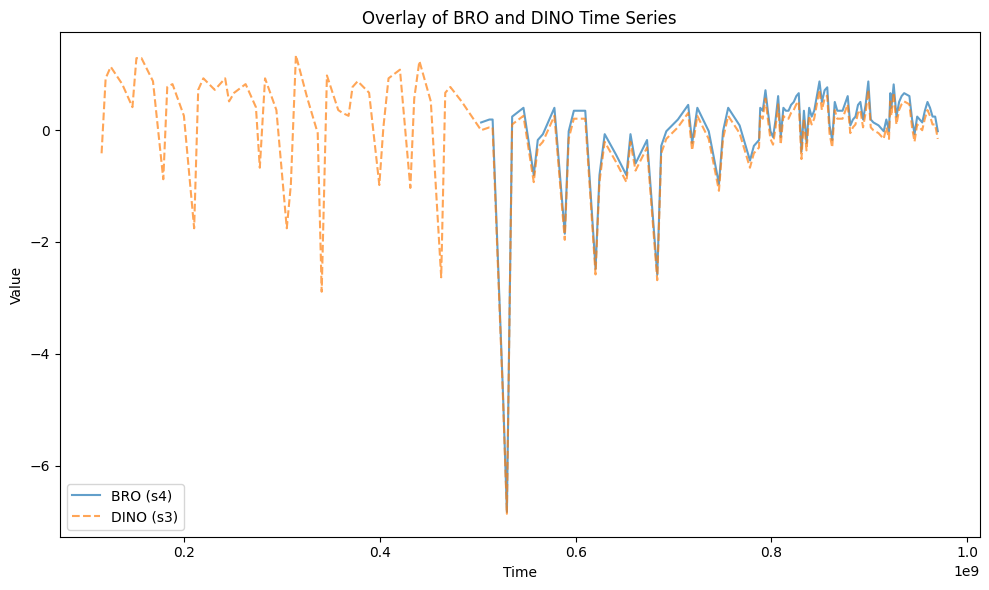

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(times['s4'], s4, label='BRO (s4)', alpha=0.7)
plt.plot(times['s3'], s3, label='DINO (s3)', alpha=0.7, linestyle='--')

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Overlay of BRO and DINO Time Series")
plt.legend()
plt.tight_layout()
plt.show()

## Export data for use in other notebooks

In [ ]:
# Export to a binary file using pickle
with open('../../data/4_time_series.pkl', 'wb') as f:
    pickle.dump({'times': times, 'series': series}, f)

NameError: name 'times' is not defined

## Example of importing the data

In [ ]:
with open('../../data/4_time_series.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
times = loaded_data['times']
series = loaded_data['series']

## Test-dataset exploration

In [2]:
with open(f"../../data/1140_sample_migrated_GLD_dino+bro.pkl", 'rb') as f:
    data = pickle.load(f)
meta_obs = data['meta']
data_obs = data['data']
print(len(meta_obs), len(data_obs))

1140 1140


In [ ]:
# Loop trough the data
for i, gld in enumerate(data_obs.keys()):
    dino_ts = data_obs[gld]['dino']
    bro_ts = data_obs[gld]['bro']
    # normalization
    dino_ts[:, 1] = (dino_ts[:, 1] - np.mean(dino_ts[:, 1])) / np.std(dino_ts[:, 1])
    bro_ts[:, 1] = (bro_ts[:, 1] - np.mean(bro_ts[:, 1])) / np.std(bro_ts[:, 1])

Average length of time series in test-dataset: 368.659649122807
Max length: 30275, Min length: 2


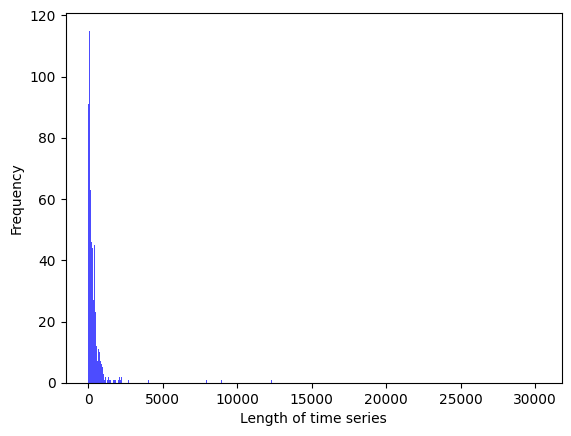

In [ ]:
# Analysis of time-series lengths
lengths = [len(data_obs[gld]['dino']) for gld in data_obs.keys()]
average_length = np.mean(lengths)
print(f"Average length of time series in test-dataset: {average_length}")
print(f"Max length: {np.max(lengths)}, Min length: {np.min(lengths)}")

plt.hist(lengths, bins=1000, color='blue', alpha=0.7)
plt.xlabel("Length of time series")
plt.ylabel("Frequency");

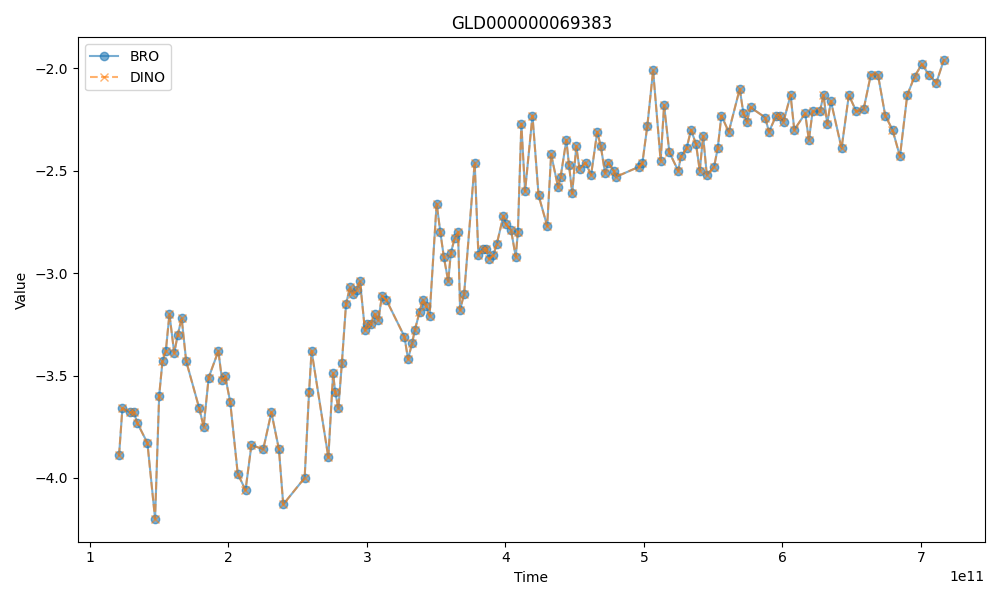

In [3]:
# Visualization of a specific time series (BRO vs DINO comparison)
%matplotlib widget
gld = random.sample(list(data_obs.keys()), 1)[0]
#gld = 'GLD000000069368'
dino_ts = data_obs[gld]['dino']
bro_ts = data_obs[gld]['bro']

plt.figure(figsize=(10, 6))
plt.plot(bro_ts[:, 0], bro_ts[:, 1], label='BRO', alpha=0.6, marker='o')
plt.plot(dino_ts[:, 0], dino_ts[:, 1], label='DINO', alpha=0.6, linestyle='--', marker='x')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"{gld}")
plt.legend()
plt.tight_layout()
plt.show()

## Inventory of interesting/particular cases
We would like to have at hand some examples (i.e. GLDs) of some edge cases. We are going to limit to series in the migration records. The following categories should be considered:
1. Coordinates changing
2. Changes in sampling rate (e.g change in sensor)
3. Partial matches
    3.1 BRO data > DINO data: migrated record with new data delivered
    3.2 DINO data > BRO data: 1-to-many
    3.3 Data split in different records
4. Data Quality Control leading to slight changes in values BRO != DINO. This could be because of an adjustment of the maaiveld, or manual inspection and correction to the data.

_Note:_ I assume that these cases are outside of the test-dataset, thus when visualizing examples we are querying directly DINO and BRO services.

### 1. Coordinates changing
No cases found on `test-dataset`

In [4]:
for gld in data_obs.keys():
    meta = meta_obs[gld]
    if meta['x_dino'] != meta['x_bro'] or meta['y_dino'] != meta['y_bro']: 
        print(f"Coordinate mismatch for {gld}: DINO({meta['x_dino']}, {meta['y_dino']}) vs BRO({meta['x_bro']}, {meta['y_bro']})")

### 2. Examples with very different sampling rates:
- 'GLD000000133160', '36647780'

#### 3. Partial matches
##### 3.1 BRO data > DINO data: 
Migrated records with new data delivered
- 'GLD000000034136', '36646383'
- 'GLD000000072935', '36604583' (Although new data is constant)

Resampled data (QC?): gaps in DINO replaced by other data in BRO [See also category 4].
- 'GLD000000071472', '36593104'
- 'GLD000000060574', '36583761'


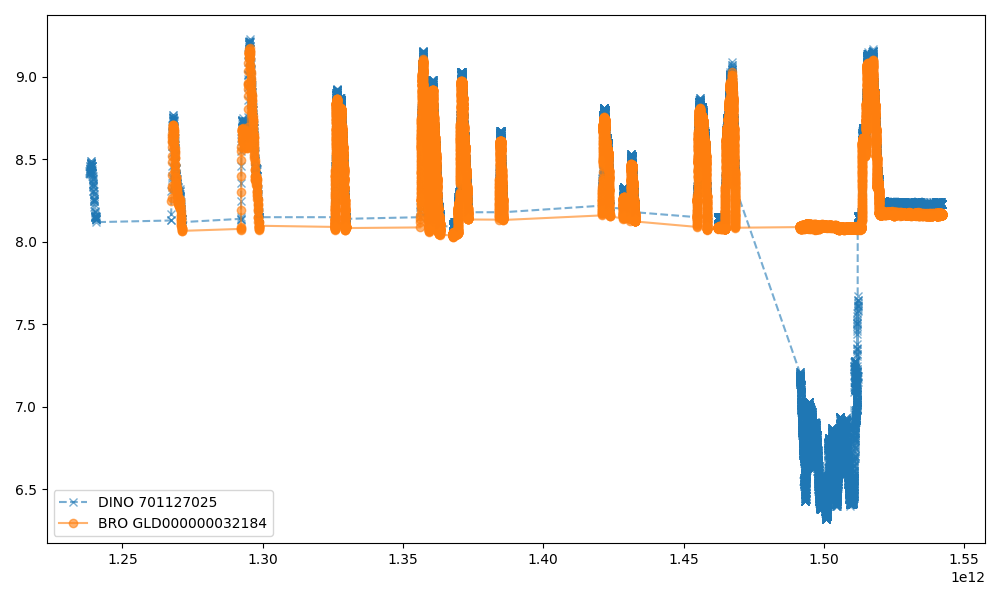

In [15]:
%matplotlib widget
gld, piezo_dbk = 'GLD000000032184', '701127025'
plt.figure(figsize=(10, 6))
dino_ts = utils_dino.get_DINO_data_by_piezometer(piezo_dbk)[['monitor_date', 'value']].values
plt.plot(dino_ts[:, 0], dino_ts[:, 1], label=f"DINO {piezo_dbk}", alpha=0.6, linestyle='--', marker='x')
bro_ts = utils_bro.get_bro_data(gld).iloc[:, [0, -1]].values
plt.plot(bro_ts[:, 0], bro_ts[:, 1], label=f"BRO {gld}", alpha=0.6, marker='o')
plt.legend()
plt.tight_layout()
plt.show()

##### 3.2 DINO data > BRO data: 1-to-many
- **Small differences** ~ 10 points: Removal of minima (internal control of BRO?) -> Gaps (in DINO) replaced by other data (in BRO) (See 4.)
- **Big differences**: Split records. See examples in `data/piezo_multiple_bro_id.pkl`
- **Other:**
    - Removal of DINO data 'GLD000000109831', '36665245'
##### 3.3 Data split in different records
For a given PIEZOMETER_DBK, multiple GLD. 
- Identifiers stored in: `data/piezo_multiple_bro_id.pkl`
- Data stored in: `data/1233_sample_migrated_GLD_split.pkl`

_Both should have the same records: dataset was created from looping trough identifiers_

In [4]:
# Load identifiers of records in this category
with open("../../data/piezo_multiple_bro_id.pkl", "rb") as f:
    piezo_multiple_bro_id = pickle.load(f)
    
# Load the data (no query to DINO nor BRO needed)
with open("../../data/1233_sample_migrated_GLD_split.pkl", "rb") as f:
    splits_dataset = pickle.load(f)
splits_data = splits_dataset['data']
print(f"Dataset has {len(splits_data)} GLD records. \nIdentifiers database has {len(piezo_multiple_bro_id)} PIEZOMETER_DBK records")

Dataset has 1233 GLD records. 
Identifiers database has 2669 PIEZOMETER_DBK records


Piezometer DBK: 36594235 has BRO_IDs: ['GLD000000055466' 'GLD000000055562' 'GLD000000055822']


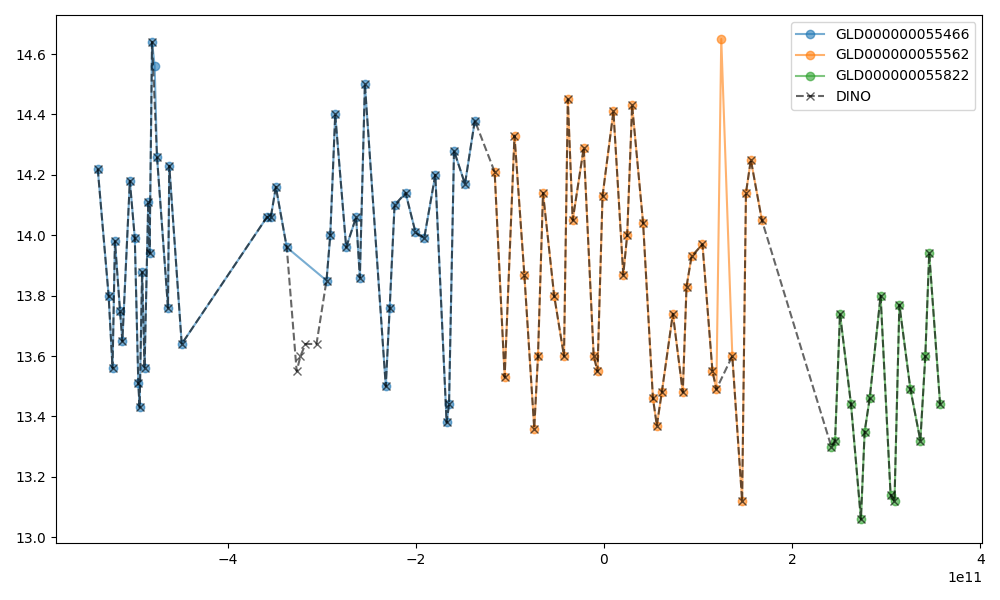

In [24]:
# Plot a record from the pre-loaded data
piezo_dbk = random.sample(list(piezo_multiple_bro_id.keys()), 1)[0]
bro_ids = piezo_multiple_bro_id[piezo_dbk]
print(f"Piezometer DBK: {piezo_dbk} has BRO_IDs: {bro_ids}")
plt.figure(figsize=(10, 6))
for gld in bro_ids:
    bro_ts = splits_data[gld]['bro']
    plt.plot(bro_ts[:, 0], bro_ts[:, 1], label=gld, alpha=0.6, marker='o')
dino_ts = splits_data[gld]['dino']
plt.plot(dino_ts[:, 0], dino_ts[:, 1], label='DINO', alpha=0.6, linestyle='--', marker='x', color='k')
plt.legend()
plt.tight_layout()
plt.show()

Piezometer DBK: 36669521 has BRO_IDs: ['GLD000000059173' 'GLD000000059176' 'GLD000000058889']


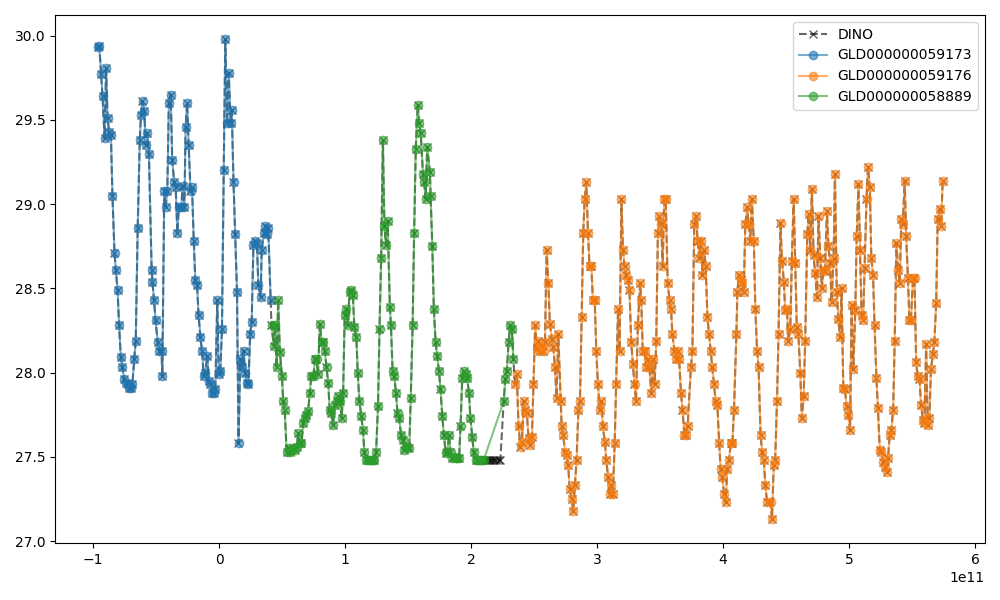

In [ ]:
#Plot a record by querying BRO and DINO services
#piezo_dbk = '36583699'
piezo_dbk = random.sample(list(piezo_multiple_bro_id.keys()), 1)[0]
bro_ids = piezo_multiple_bro_id[piezo_dbk]
print(f"Piezometer DBK: {piezo_dbk} has BRO_IDs: {bro_ids}")

plt.figure(figsize=(10, 6))
dino_ts = utils_dino.get_DINO_data_by_piezometer(piezo_dbk)[['monitor_date', 'value']].values
plt.plot(dino_ts[:, 0], dino_ts[:, 1], label=f"DINO {piezo_dbk}", alpha=0.6, linestyle='--', marker='x', color='k')
for gld in bro_ids:
    bro_ts = utils_bro.get_bro_data(gld).iloc[:, [0, -1]].values
    plt.plot(bro_ts[:, 0], bro_ts[:, 1], label=gld, alpha=0.6, marker='o')
plt.legend()
plt.tight_layout()
plt.show()

We see that a lot of the splits are also for gaps that exist in DINO data.

### 4. Important differences (QC?) between BRO and DINO
- GLD000000059834 
- GLD000000059632 : two extreme (low) points were removed

Correction of vertical scale:
- 'GLD000000032184', '701127025' -> Very interesting case of same well and tube that looks quite different.

Various minima removed
- GLD000000059700
- GLD000000054782
- 'GLD000000056780', '36630263'
'GLD000000059187', '36664063'

Gaps (in DINO) replaced by other data (in BRO):
- by maxima or constant value:
    - 'GLD000000074340', '36638882'
    - 'GLD000000053948', '36657851'
    - 'GLD000000034823', '36648155'
    - 'GLD000000076716', '36661068'
    - 'GLD000000078831', '36596607'
- 'GLD000000073526', '36661056'

Constant measurement (in DINO) removed: created a gap (in BRO)
- 'GLD000000079882', '36664925'
- 'GLD000000058490', '36655265'
- 'GLD000000057459', '36629931'

Changes without clear pattern
- 'GLD000000055764', '36592646'

Out of scope: 
Found GLD object in BRO that does not have a GWM: `'GLD000000071614'`. One can retrieve a time series via the REST API but:
- is not findable in the portal, and
- there is not well (GMW) object attached to it.